In [1]:
# look at the data's distribution
# and calculate variograms
# AND look at how to calibrate data with neighboring pairs of sensors
#... and play with kriging

In [2]:
# NOTE: perform calculations with pm2.5 values first, then convert to aqi at the end
# OR! try this -- may be more amenable to calculations with AQI

In [1]:
import numpy as np
from urllib.request import urlopen
import json
import decimal
from scipy.stats import expon, norm, lognorm
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pykrige.kriging_tools as kt 
from pykrige.ok import OrdinaryKriging
from skgstat import Variogram
import shapely.geometry
import pyproj
import math
import aqi
import csv

#the northeast:
bbox = {
    'nwlat': '42.0', #"49.0",
    'nwlng': '-80.0', #"-125.0",
    'selat': '37.0', #"24.0",
    'selng': '-70.0' #"-66.0"   
}

sensorData = {
    'source': [],
    'lon': [],
    'lat': [],
    'pm25': [],
    'aqi': []
}

check_indoors = True

# load the purpleair ID data for checking if sensors are outdoors
outsideIDs = []
with open('purpleair_outside_ids.csv', 'r') as csvfile:
    reader = csv.reader(csvfile) 
    for row in reader:
        for item in row:
            outsideIDs.append(int(item))

In [2]:
# utility: get grid for kriging
def getResolution(s, e):
    resolution = math.sqrt(abs(e[1]-s[1])*abs(e[0]-s[0])/70000.)
    return resolution

def getGrid(bbox):
    # ...assistance from here: https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python

    # define projections:
    p_ll = pyproj.Proj(init='epsg:4326') # lon/lat
    p_mt = pyproj.Proj(init='epsg:3857') # metric; same as EPSG:900913

    # Create corners of rectangle to be transformed to a grid
    nw = shapely.geometry.Point((float(bbox['nwlng']), float(bbox['nwlat'])))
    se = shapely.geometry.Point((float(bbox['selng']), float(bbox['selat'])))

    # Project corners to target projection
    s = pyproj.transform(p_ll, p_mt, nw.x, nw.y) # Transform NW point to 3857
    e = pyproj.transform(p_ll, p_mt, se.x, se.y) # .. same for SE

    #FIXME: for now, fixed resolution...
    stepsize = getResolution(s, e) # m grid step size

    # Iterate over 2D area
    #for the deck.gl layer, we need the top left coords of these cells
    x_grid = []
    y_grid = []
    x_centers = []
    y_centers = []
    x = s[0]
    dim = 0
    while x < e[0]:
        dimension = dim
        dim = 0
        y = e[1]
        while y < s[1]:
            p = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, x, y))
            x_grid.append(p.x)
            y_grid.append(p.y)
            y += stepsize
            dim += 1
        x += stepsize

    return ({'x_grid': x_grid, 'y_grid': y_grid, 'resolution': stepsize, 'dimension': dimension})

In [3]:
# utility: scale values 
def scaleAQI(val):
    if val > 150:
        val = 150
    return val / 150.

def scaleAQIBin(val): # get the color for this bin
    if val < 50:
        return '#abdda4'
    elif val >= 50 and val < 100:
        return '#e6f598'
    elif val >= 100 and val < 150:
        return '#fee08b'
    elif val >= 150 and val < 200:
        return '#f46d43'
    elif val >= 200 and val < 300:
        return '#d53e4f'
    elif val >= 300:
        return '#9e0142'
    else:
        return '#000000'
    

In [4]:
#utility: check if sensor is indoors
def checkSensorOutside(ID):
    outside = False
    if ID in outsideIDs:
        outside = True
    return outside

In [5]:
# purpleair request:
def getPurpleAirData(sensorData, bbox):
    path =  "https://www.purpleair.com/data.json?fetch=true&nwlat=" + bbox['nwlat'] + "selat=" + bbox['selat'] + "nwlng=" + bbox['nwlng'] + "selng=" + bbox['selng']
            
    with urlopen(path) as rawData:
        string = rawData.read().decode('utf-8')
    
    result = json.loads(string, parse_float=decimal.Decimal)
    fields = result['fields']
    data = result['data']
    
    # for below: 
    # if the "check_indoors" flag is on, request the individual data for each one & check
    
    for row in data:
        if str(row[fields.index('pm')]) != 'None':
            if row[fields.index('Lon')] > float(bbox['nwlng']): 
                if row[fields.index('Lon')] < float(bbox['selng']):
                    if row[fields.index('Lat')] < float(bbox['nwlat']):
                        if row[fields.index('Lat')] > float(bbox['selat']):
                            if checkSensorOutside(row[fields.index('ID')]) == True:
                                sensorData['source'].append('purpleAir')
                                sensorData['lon'].append(row[fields.index('Lon')])
                                sensorData['lat'].append(row[fields.index('Lat')])
                                sensorData['pm25'].append(row[fields.index('pm')])
                                sensorData['aqi'].append(aqi.to_iaqi(aqi.POLLUTANT_PM25, str(row[fields.index('pm')]), algo=aqi.ALGO_EPA))

In [6]:
def getAirNowData(sensorData, bbox):    
    apiKey = "AF896438-7F72-4518-B975-3A10142F3FCE"
    options = {}
    options["url"] = "https://airnowapi.org/aq/data/"
    options["parameters"] = "pm25"
    options["bbox"] = bbox['nwlng'] + ',' + bbox['selat'] + ',' + bbox['selng'] + ',' + bbox['nwlat']
    options["data_type"] = "b"
    options["format"] = "application/json"
    options["ext"] = "json"
    options["api_key"] = "AF896438-7F72-4518-B975-3A10142F3FCE"

    path = options["url"] \
                  + "?parameters=" + options["parameters"] \
                  + "&bbox=" + options["bbox"] \
                  + "&datatype=" + options["data_type"] \
                  + "&format=" + options["format"] \
                  + "&api_key=" + options["api_key"]

    with urlopen(path) as rawData:
        string = rawData.read().decode('utf-8')
        result = json.loads(string, parse_float=decimal.Decimal)

    for item in result:
        if item['Value'] > 0.0:
            sensorData['source'].append('airNow')
            sensorData['lon'].append(item['Longitude'])
            sensorData['lat'].append(item['Latitude'])
            sensorData['pm25'].append(item['Value'])
            sensorData['aqi'].append(aqi.to_iaqi(aqi.POLLUTANT_PM25, str(item['Value']), algo=aqi.ALGO_EPA))

In [7]:
getAirNowData(sensorData, bbox)
getPurpleAirData(sensorData, bbox)

In [8]:
print('AirNow sources: ',
      len([source for source in sensorData['source'] if source == 'airNow']))
print('PurpleAir sources: ',
      len([source for source in sensorData['source'] if source == 'purpleAir']))

AirNow sources:  77
PurpleAir sources:  215


In [9]:
# understand the ranges:
airNowData = [float(aqi) for idx, aqi in enumerate(sensorData['aqi']) if sensorData['source'][idx] == 'airNow']
purpleAirData = [float(aqi) for idx, aqi in enumerate(sensorData['aqi']) if sensorData['source'][idx] == 'purpleAir']
allData = [float(aqi) for aqi in sensorData['aqi']]

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


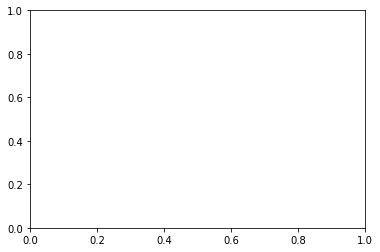

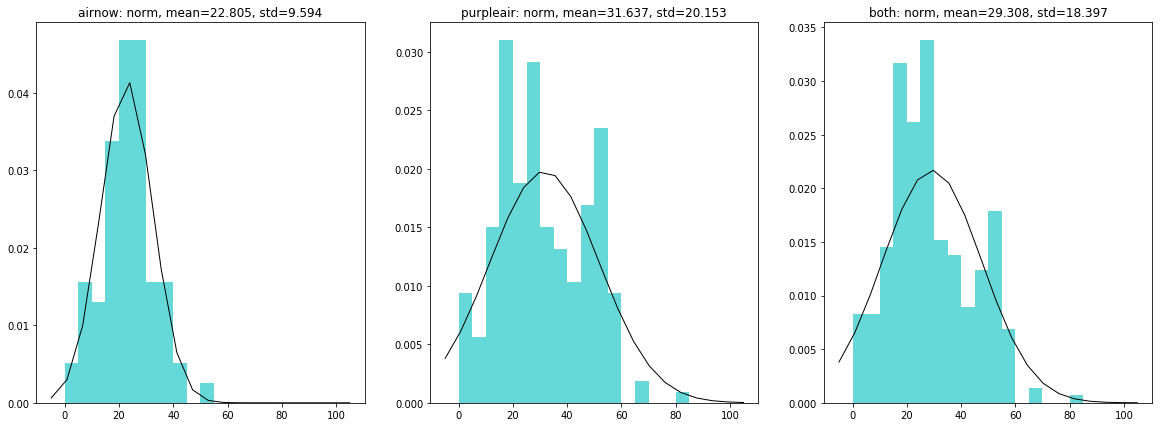

In [10]:
plt.cla()
# look at the distributions
hrange = (0,100)
plt.figure(figsize=(20, 7))
plt.subplot(1, 3, 1)
mu, std = norm.fit(airNowData)
ahist=plt.hist(airNowData, bins=20, normed=True, alpha=0.6, color='c',range=hrange)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 20)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=1)
plt.title("airnow: norm, mean=" + str(round(mu, 3)) + ", std=" + str(round(std, 3)))

plt.subplot(1, 3, 2)
mu, std = norm.fit(purpleAirData)
ahist=plt.hist(purpleAirData, bins=20, normed=True, alpha=0.6, color='c',range=hrange)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 20)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=1)
plt.title("purpleair: norm, mean=" + str(round(mu, 3)) + ", std=" + str(round(std, 3)))

plt.subplot(1, 3, 3)
mu, std = norm.fit(allData)
ahist=plt.hist(allData, bins=20, normed=True, alpha=0.6, color='c',range=hrange)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 20)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=1)
title = ("both: norm, mean=" + str(round(mu, 3)) + ", std=" + str(round(std, 3)))
th=plt.title(title)

plt.show()

In [11]:
# convert coordinates to metric...
lonlat_proj = pyproj.Proj(init='epsg:4326') # lon/lat
metric_proj = pyproj.Proj(init='epsg:3857') # metric; same as EPSG:900913

#ok, the variogram of airnow data alone is reasonable....
coordinates = []
values = []
for i in range(len(sensorData['source'])):
    lonlat_coord = shapely.geometry.Point((sensorData['lon'][i], sensorData['lat'][i]))
    metric_coord = pyproj.transform(lonlat_proj, metric_proj, lonlat_coord.x, lonlat_coord.y) 
    coordinates.append((sensorData['lon'][i], sensorData['lat'][i]))
    values.append(float(sensorData['aqi'][i])) # transform w/ log because the distribution is skewed

# check whether measuring distances in the projection is reasonable -- 
# i.e., are the distances correlated with the actual (haversine) distances?



In [12]:
"""haversine_dists = []
euclidean_dists = []

# get the haversine dist between the [lon, lat] pairs,
# then compare with the projected dist
for a in range(len(sensorData['source'])):
    for b in range(len(sensorData['source'])):
        a_coords_latlon = (sensorData['lat'][a], sensorData['lon'][a])
        b_coords_latlon = (sensorData['lat'][b], sensorData['lon'][b])
        a_coords_metric = np.asarray(coordinates[a])
        b_coords_metric = np.asarray(coordinates[b])
        haversine_dists.append(1000*haversine(a_coords_latlon, b_coords_latlon)) # lat, lon :(
        #euclidean_dist = np.linalg.norm(a_coords_metric-b_coords_metric)
        euclidean_dists.append(distance.euclidean(a_coords_metric, b_coords_metric))

plt.scatter(haversine_dists, euclidean_dists)
plt.show()
"""
#this deviates from linear pretty strongly at the scales i'm requesting. probably better to use smaller scales...

"haversine_dists = []\neuclidean_dists = []\n\n# get the haversine dist between the [lon, lat] pairs,\n# then compare with the projected dist\nfor a in range(len(sensorData['source'])):\n    for b in range(len(sensorData['source'])):\n        a_coords_latlon = (sensorData['lat'][a], sensorData['lon'][a])\n        b_coords_latlon = (sensorData['lat'][b], sensorData['lon'][b])\n        a_coords_metric = np.asarray(coordinates[a])\n        b_coords_metric = np.asarray(coordinates[b])\n        haversine_dists.append(1000*haversine(a_coords_latlon, b_coords_latlon)) # lat, lon :(\n        #euclidean_dist = np.linalg.norm(a_coords_metric-b_coords_metric)\n        euclidean_dists.append(distance.euclidean(a_coords_metric, b_coords_metric))\n\nplt.scatter(haversine_dists, euclidean_dists)\nplt.show()\n"

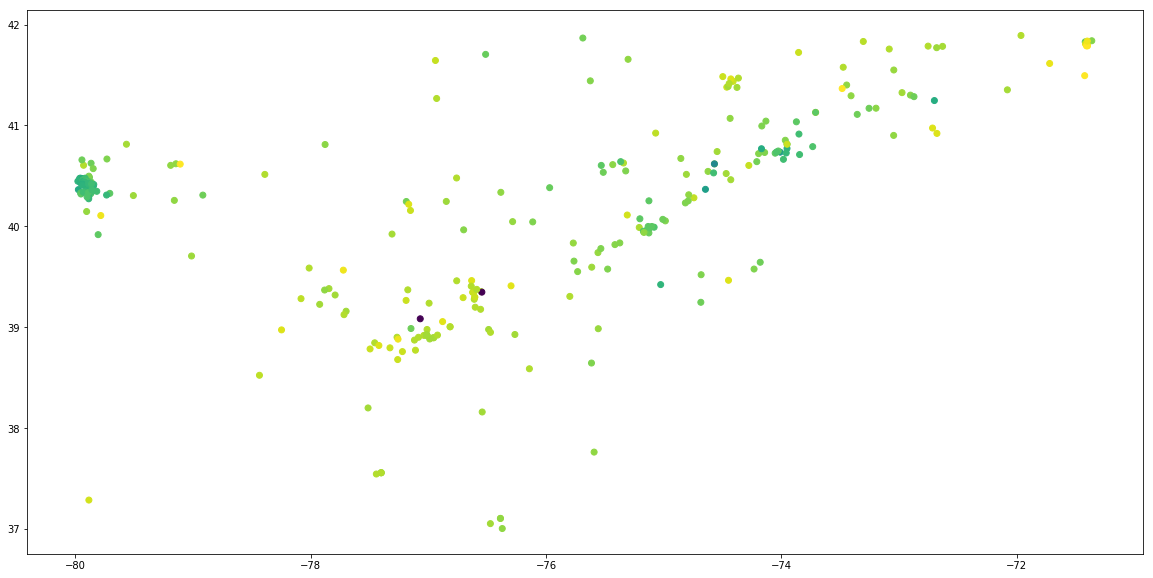

In [13]:
#let's look at the spatial distribution of the data:
scaled_vals = [scaleAQI(float(aqi)) for aqi in sensorData['aqi']]
plt.figure(figsize=(20,10))
plt.scatter([coord[0] for coord in coordinates], [coord[1] for coord in coordinates], marker='o', c=scaled_vals, cmap=cm.viridis_r)
plt.show()

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   13.85
Sill:              213898.63
Nugget:            0.00
        


//anaconda/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


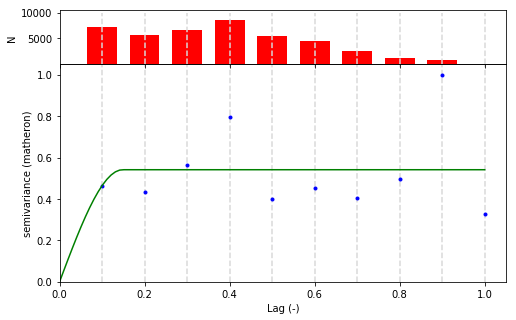

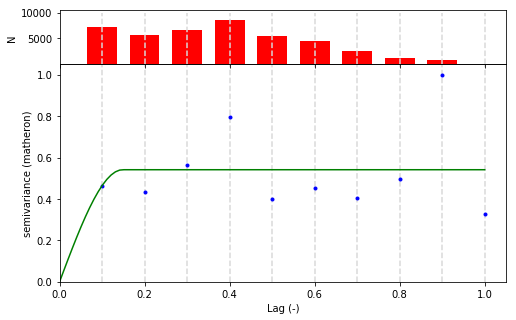

In [14]:
var = Variogram(coordinates=coordinates, values=values, n_lags=10)
print(var) # this is the 'dumb' version -- euclidean coordinates
var.plot()

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


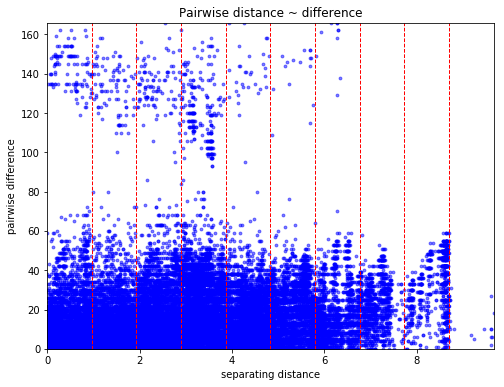

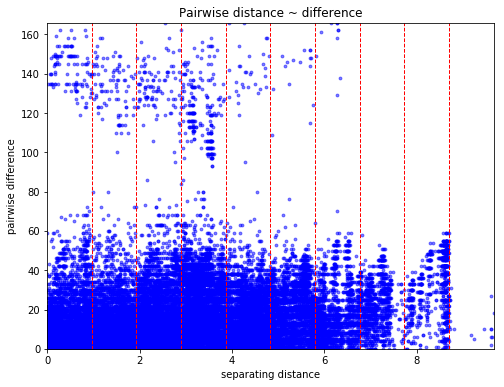

In [15]:
var.distance_difference_plot()

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'spherical' Variogram Model
Partial Sill: 262.047211571
Full Sill: 342.563313828
Range: 0.962774694882
Nugget: 80.5161022571 

Calculating statistics on variogram model fit...


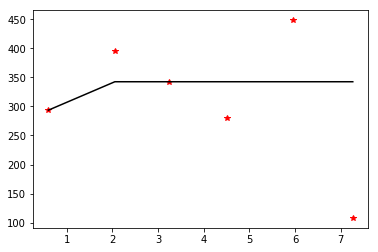

In [17]:

data = [float(s) for idx, s in enumerate(sensorData['aqi'])]# if sensorData['source'][idx] == 'purpleAir']
lon = [np.remainder(l, 360) for idx, l in enumerate(sensorData['lon'])]# if sensorData['source'][idx] == 'purpleAir'] # i.e., x position; convert from [-180, 180] to [0, 360] longitude coordinates
lat = [l for idx, l in enumerate(sensorData['lat'])]# if sensorData['source'][idx] == 'purpleAir'] # i.e., y position

OK = OrdinaryKriging(lon, lat, data, variogram_model='spherical', coordinates_type='geographic', nlags=6, verbose=True)
OK.display_variogram_model()

In [18]:
#convert the x grid to OK-friendly coords:
grid = getGrid(bbox)
x_adjusted = [x % 360 for x in grid['x_grid']]

In [19]:
z, ss = OK.execute('points', x_adjusted, grid['y_grid'])
#kt.write_asc_grid(grid['x_grid'], grid['y_grid'], z, filename="output.asc")

Executing Ordinary Kriging...



0.114484836431
0.11263496575435847


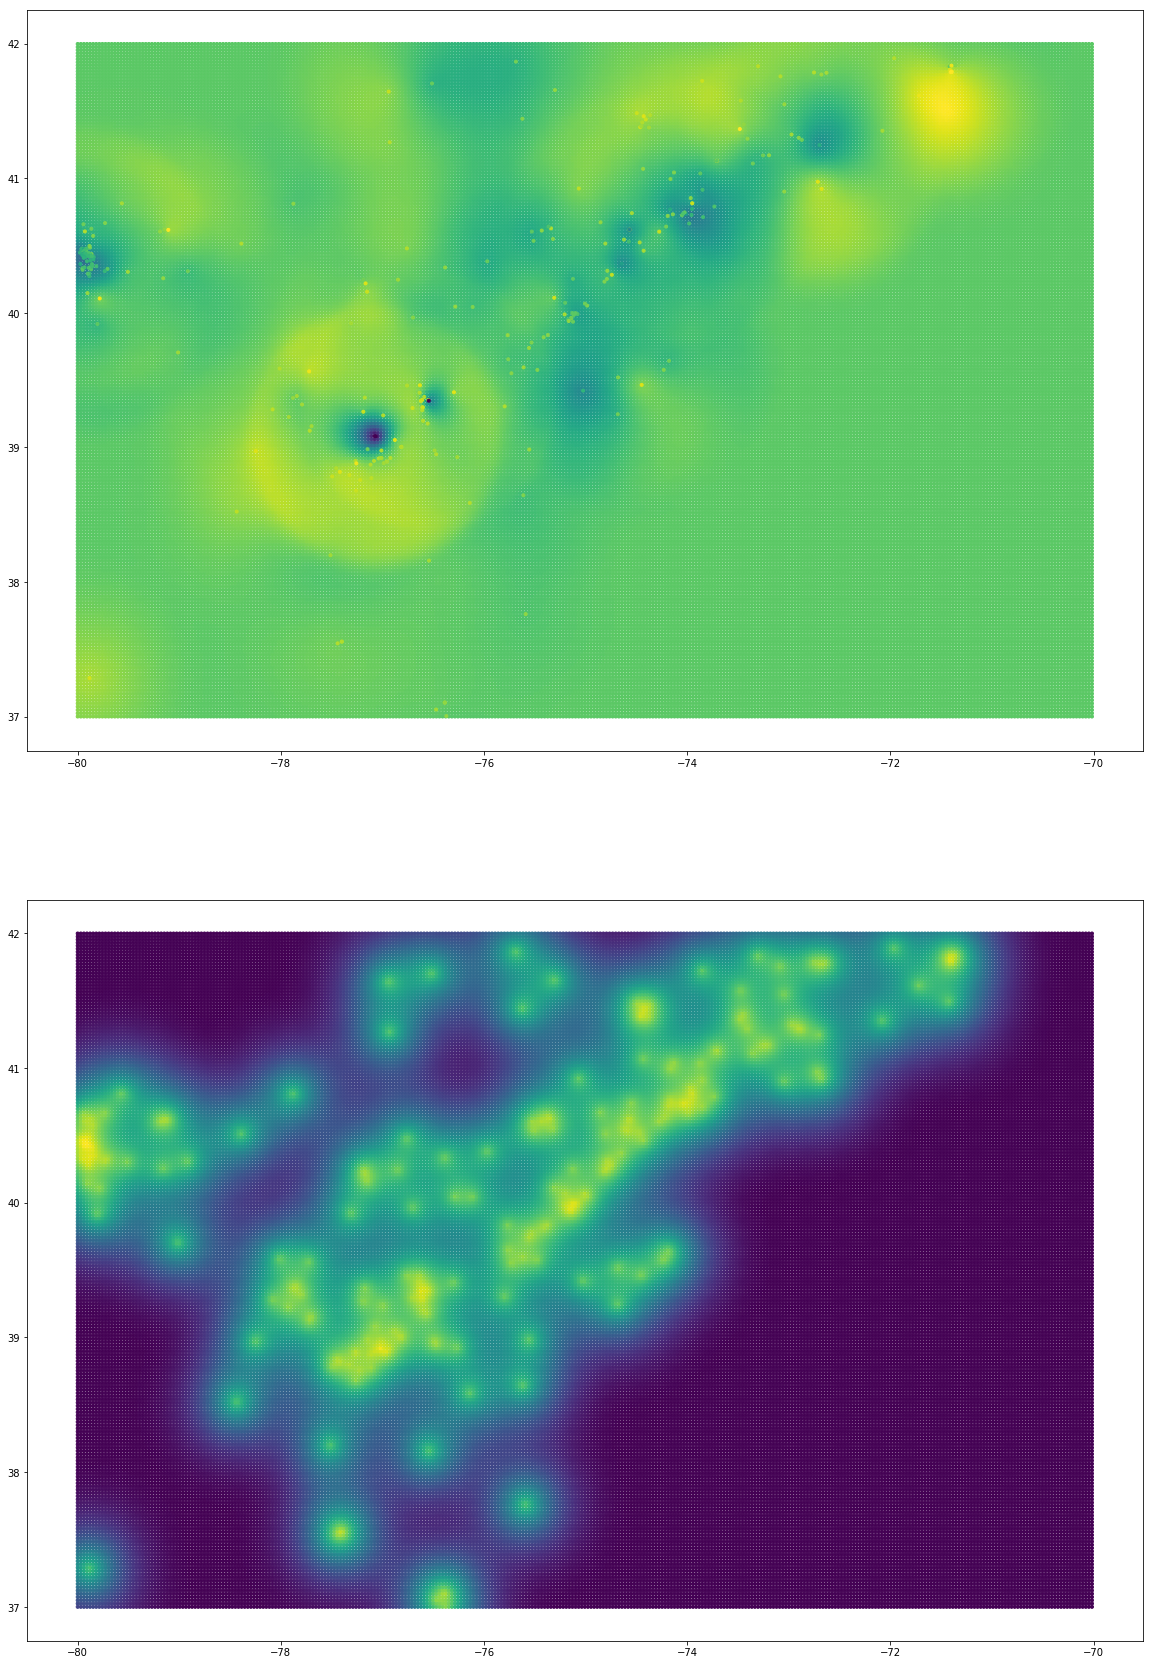

In [21]:
# let's plot the kriged prediction! ahhH!
# scale the values to the same scale:

# we did the prediction with the logged values, so take the exp to convert back:
# this seems like it could introduce a lot of error?
#z_adjusted = [math.exp(z_val) for z_val in z] 
#ss_adjusted = [math.exp(ss_val) for ss_val in ss]
#vals_adjusted = [math.log(val + 0.001) for val in scaled_vals]
z_scaled = [scaleAQI(z_val) for z_val in z]
ss_scaled = [scaleAQI(math.sqrt(ss_val)) for ss_val in ss]

print(z_scaled[0])
print(ss_scaled[0])

plt.figure(figsize=(20,30))

plt.subplot(2, 1, 1)
plt.scatter([x for x in grid['x_grid']], [y for y in grid['y_grid']], marker='.', c=z_scaled, cmap=cm.viridis_r)
plt.scatter([coord[0] for coord in coordinates], [coord[1] for coord in coordinates], marker='.', c=scaled_vals, cmap=cm.viridis_r)

#plt.scatter([x for x in grid['x_grid']], [y for y in grid['y_grid']], marker='.', c=[]
#        ]])

plt.subplot(2, 1, 2)
plt.scatter([x for x in grid['x_grid']], [y for y in grid['y_grid']], marker='.', c=ss_scaled, cmap=cm.viridis_r)
plt.show()

In [22]:
print(np.mean(z))
print(np.mean([math.sqrt(ss_val) for ss_val in ss])) # *** take the square root!!!! :D

22.2234561381
16.4550822305


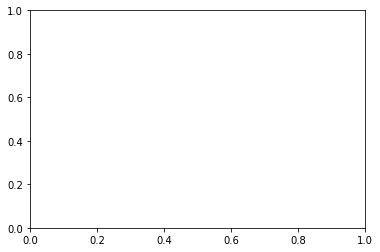

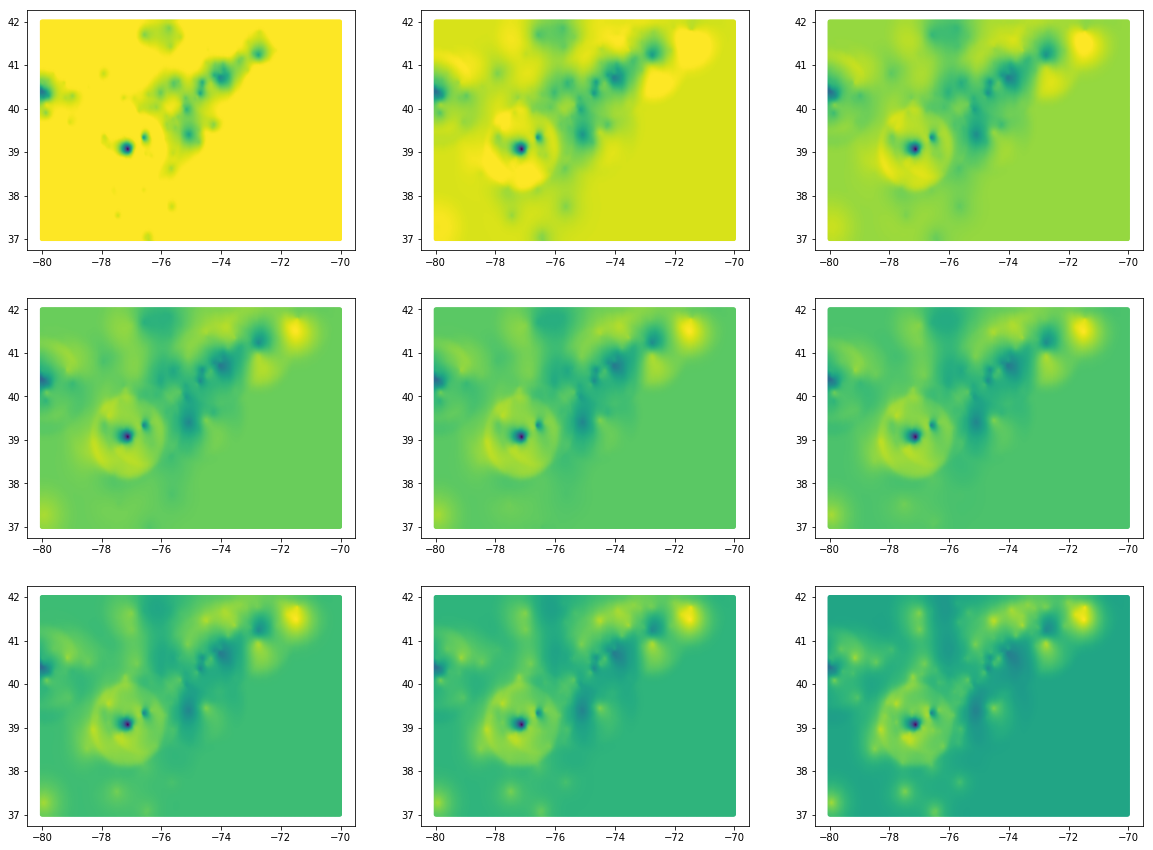

In [23]:
# how much variation is there in ss? plot just one +/- 
plt.cla()
plt.figure(figsize=(20, 15))

n_multiples = 9

# for each small multiple,
for n in range(n_multiples):
# get the z-score (?) for this quantile:
    multiple = []
    percentile = (n + 0.5)/9.

    for i in range(len(ss_scaled)):
        score = norm.ppf(percentile, loc=z_scaled[i], scale=ss_scaled[i])
        multiple.append(np.amax([score, 0.0]))

    plt.subplot(3, 3, n+1)
    plt.scatter([x for x in grid['x_grid']], [y for y in grid['y_grid']], marker='.', c=multiple, cmap=cm.viridis_r)
    
plt.show()

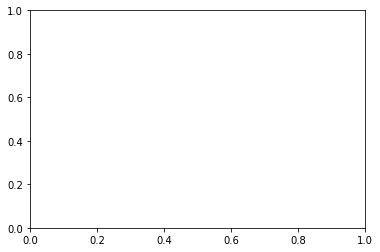

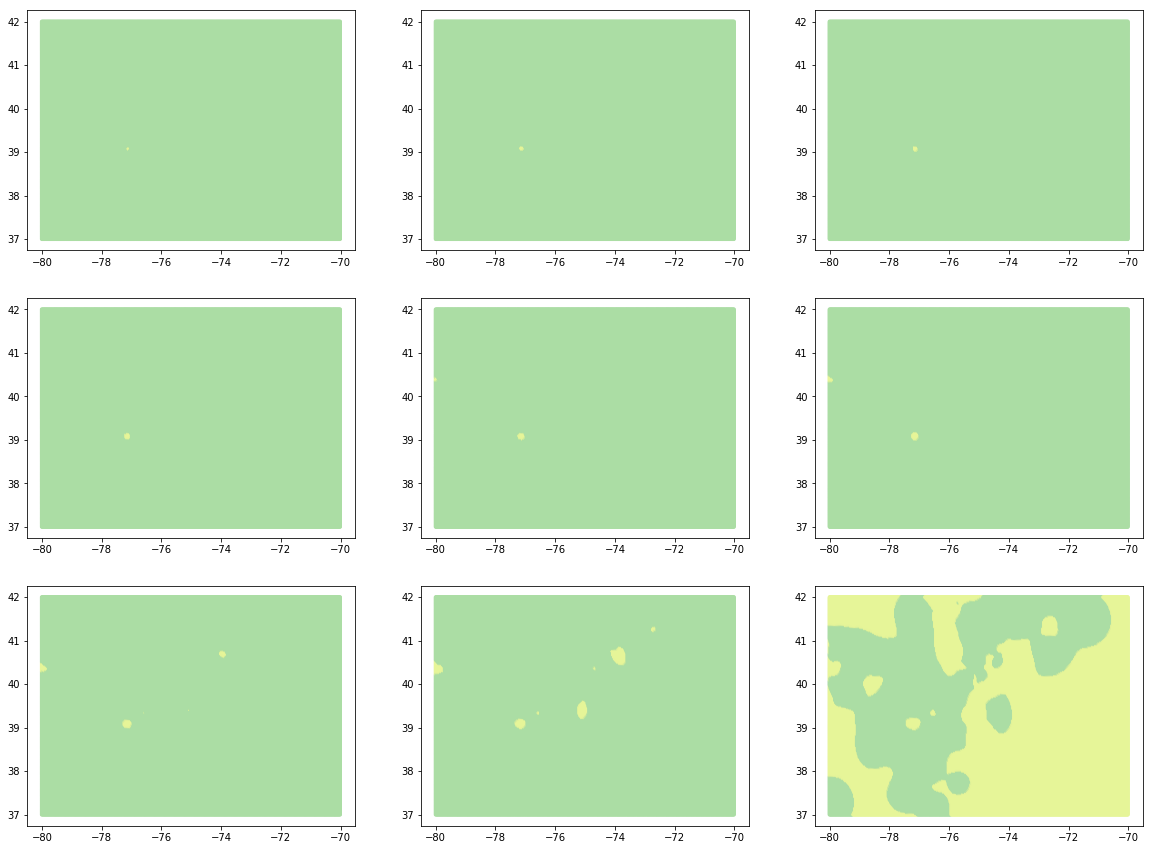

In [24]:
plt.cla()
plt.figure(figsize=(20, 15))

n_multiples = 9

std_dev = [math.sqrt(ss_val) for ss_val in ss]
z_color = [scaleAQIBin(z_val) for z_val in z]

# for each small multiple,
for n in range(n_multiples):
# get the z-score (?) for this quantile:
    multiple = []
    percentile = (n + 0.5)/float(n_multiples)

    for i in range(len(ss_scaled)):
        score = norm.ppf(percentile, loc=z[i], scale=std_dev[i])
        multiple.append(np.amax([score, 0.0]))

    colors = [scaleAQIBin(m) for m in multiple]
    plt.subplot(int(math.sqrt(n_multiples)), int(math.sqrt(n_multiples)), n+1)
    plt.scatter([x for x in grid['x_grid']], [y for y in grid['y_grid']], marker='.', c=colors)
    
plt.show()

In [ ]:
# how to depict the "draws" from the probability distribution for the small multiples?
plt.cla()
plt.figure(figsize=(20, 15))

n_multiples = 9

std_dev = [math.sqrt(ss_val) for ss_val in ss]
z_color = [scaleAQIBin(z_val) for z_val in z]

std_dev_avg = scipy.stats.mean(std_dev)
z_avg = scipy.stats.mean(z)

likelihoods = []

# for each small multiple,
for n in range(n_multiples):
# get the z-score (?) for this quantile:
    percentile = (n + 0.5)/float(n_multiples)

    # try it with the averages first:
    
    score = norm.ppf(percentile, loc=z[i], scale=std_dev[i])
    likelihoods.append(np.amax([score, 0.0]))

    colors = [scaleAQIBin(m) for m in multiple]
    
plt.subplot(int(math.sqrt(n_multiples)), int(math.sqrt(n_multiples)), n+1)
plt.scatter([x for x in grid['x_grid']], [y for y in grid['y_grid']], marker='.', c=colors)
    
plt.show()